In [1]:
import numpy as np
from Homework_3_function_headers_group_3 import fdtd_1d, fdtd_3d
from matplotlib import pyplot as plt


plt.rcParams.update({
        'figure.figsize': (12/2.54, 9/2.54),
        'figure.subplot.bottom': 0.15,
        'figure.subplot.left': 0.165,
        'figure.subplot.right': 0.90,
        'figure.subplot.top': 0.9,
        'axes.grid': False,
})

plt.close('all')

In [47]:
background_dark = True
if background_dark:
    plt.style.use('dark_background')

# 1D FDTD
## Implementation
The electric field is determined using the values of the magnetic field from the previous iteration. However, only the interior 2:Nx-1 of the electric field is updated. The derivative of the magnetic field is obtained by subtracting the magnetic field value of index 1:Nx-2 from the magnetic field value of index 2:Nx-1. Since the spatial dimension of the magnetic field has a length of Nx-1, a vector with Nx-2 elements is generated. eps_rel has the same grid as the electric field and is indexed in the same way. Subtracting the source currents gives the new electric field. In this process, the source time is calculated according to the change in time between the current and the electric field. A complex exponential function is used to oscillate the carrier. This creates a complex source amplitude and results in the entire FDTD implementation using a complex field. In this process, all spatial coordinates of the magnetic field are updated. and there are no boundary values to be preserved. At the end of the 1D FDTD implementation, the electric and magnetic fields are converted to a common coordinate system by interpolating the magnetic field from fractional to integer exponents.

## Simulation in homogeneous medium
Simulate the propagation of an ultrashort pulse in a dispersion-free dielectric medium $\epsilon$(x)=1.

In [3]:
# constants
c = 2.99792458e8 # speed of light [m/s]
mu0 = 4*np.pi*1e-7 # vacuum permeability [Vs/(Am)]
eps0 = 1/(mu0*c**2) # vacuum permittivity [As/(Vm)]
Z0 = np.sqrt(mu0/eps0) # vacuum impedance [Ohm]

# geometry parameters
x_span = 18e-6 # width of computatinal domain [m]
n1 = 1 # refractive index in front of interface
n2 = 2 # refractive index behind interface
x_interface = x_span/4 #postion of dielectric interface

# simulation parameters
dx = 15e-9 # grid spacing [m]
time_span = 60e-15 # duration of simulation [s]

Nx = int(round(x_span/dx)) + 1 # number of grid points

# source parameters
source_frequency = 500e12 # [Hz]
source_position = 0 # [m]
source_pulse_length = 1e-15 # [s]
    
# %% create permittivity distribution and run simulation %%%%%%%%%%%%%%%%%%%%%%

eps_rel=np.ones((Nx,))
Ez, Hy, x, t=fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position, source_pulse_length)

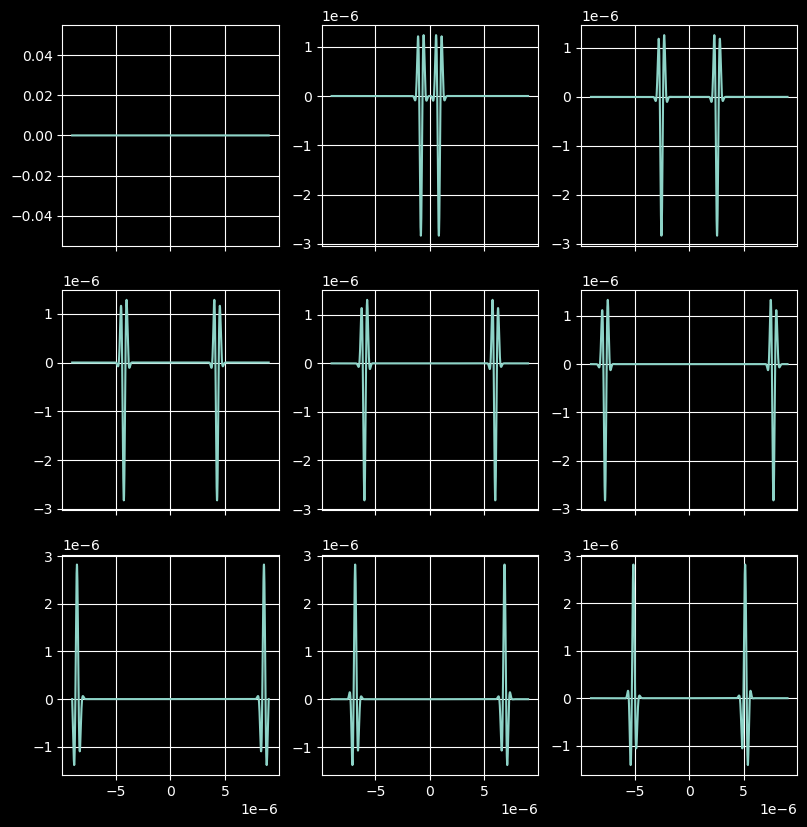

In [4]:
# %% create representative figures of the results %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

fig, ax = plt.subplots(3,3,sharex= True, figsize=(10,10))
ax = ax.flat

for i in range(9):
    ax[i].plot(x, Ez[230*i, :].real, label='E in [a.u.]')
    ax[i].grid()
    ax[i].tick_params('y') # style of line

Apparently, after colliding on the wall, field can bounce back and continue propagating because perfect conducting boundary condition is used in this task. We set the value of boundaries directly as zeros. Two boundaries act as the behavior of metal; therefore, reflection can be observed in this simulation. 

## Simulation in inhomogeneous medium
See what happens when the pulse hits the interface between two different dielectric media with permittivities $\epsilon$ 1 = 1 and $\epsilon$ 2 = 4, the interface should be located at a distance of 4.5 µm in positive direction from the center of the computational domain.

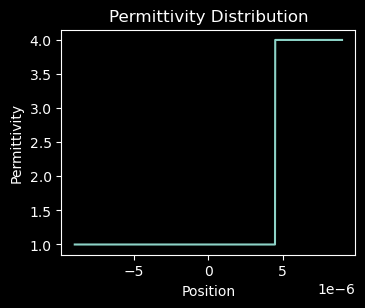

In [5]:
eps_rel=np.ones((Nx,))
indices = x >= x_span/4
eps_rel[indices] = 4
plt.figure(figsize=(4,3))
plt.plot(x, eps_rel)
plt.xlabel('Position')
plt.ylabel('Permittivity')
plt.title('Permittivity Distribution')
plt.show()

In [6]:
Ez, Hy, x, t=fdtd_1d(eps_rel, dx, time_span, source_frequency, source_position, source_pulse_length)

The propagation behavior is shown below, blue line represents the amplitude of poynting vecotor, red line represents permittivity distribution. 

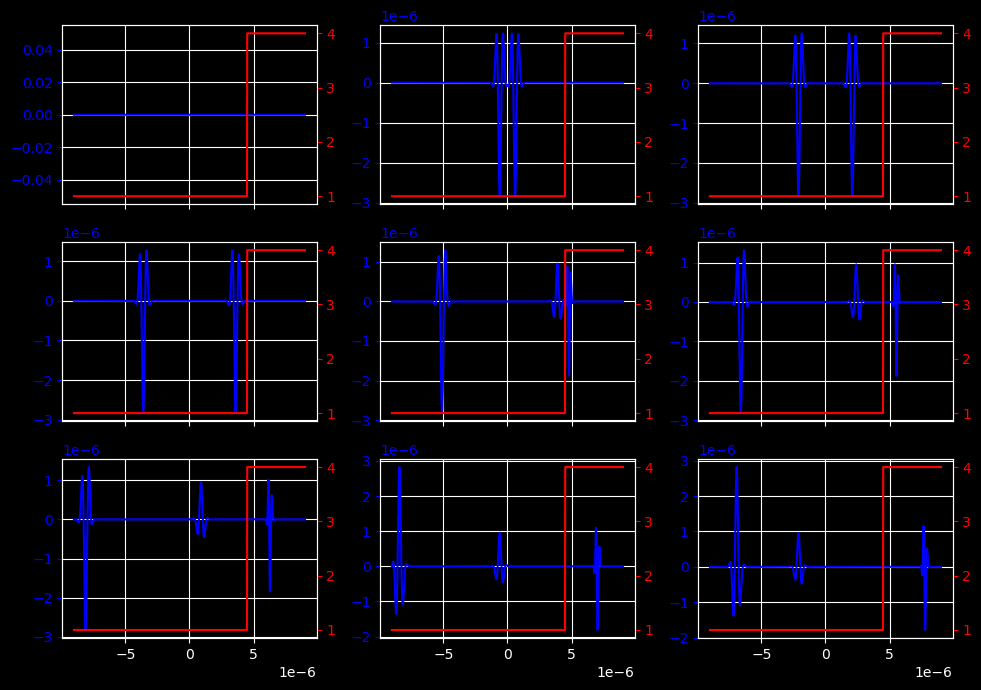

In [7]:
# %% create representative figures of the results %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
fig, ax = plt.subplots(3,3,sharex= True, figsize=(10,7))
ax = ax.flat

for i in range(9):
    ax[i].plot(x, Ez[200*i, :].real, 'b-', label='E in [a.u.]')
    ax[i].grid()
    ax[i].tick_params('y', colors='b') # style of line
    
    ax2 = ax[i].twinx()
    ax2.plot(x, eps_rel, 'r-',label='permittivity')
    ax2.tick_params('y', colors='r')
plt.tight_layout()

In this case, after the field across through the interface of different material, both transmission and reflection can be observed. Based on the formula $ \frac{(n1-n2)^2}{(n1+n2)^2} $ , the reflectance can be derived as 11%.  This can be also confirmed in the simulation that most part of field can transmit through the interface.  Similarly as previous task, after fields collide on the metal boundary, they can be totally reflected and keep propagating. 

# 3D FDTD
## implementation
The electric field components can be calculated with equations
$$
E_x|_{i+1/2,j,k}^{n+1}
=
E_x|_{i+1/2,j,k}^{n} + \frac{\Delta t}{\epsilon_0 \epsilon_{i+1/2,j,k}}
\bigg[
\frac{H_z|_{i+1/2,j+1/2,k}^{n+1/2} - H_z|_{i+1/2,j-1/2,k}^{n+1/2}}{\Delta y}
-\frac{H_y|_{i+1/2,j,k+1/2}^{n+1/2} - H_y|_{i+1/2,j,k-1/2}^{n+1/2}}{\Delta z}
-j_x|_{i+1/2,j,k}^{n+1/2}
\bigg]
$$

$$
E_y|_{i,j+1/2,k}^{n+1}
=
E_y|_{i,j+1/2,k}^{n} + \frac{\Delta t}{\epsilon_0 \epsilon_{i,j+1/2,k}}
\bigg[
\frac{H_x|_{i,j+1/2,k+1/2}^{n+1/2} - H_x|_{i,j+1/2,k-1/2}^{n+1/2}}{\Delta z}
-\frac{H_z|_{i+1/2,j+1/2,k}^{n+1/2} - H_z|_{i-1/2,j+1/2,k}^{n+1/2}}{\Delta x}
-j_y|_{i,j+1/2,k}^{n+1/2}
\bigg]
$$

$$
E_z|_{i,j,k+1/2}^{n+1}
=
E_z|_{i,j,k+1/2}^{n} + \frac{\Delta t}{\epsilon_0 \epsilon_{i,j,k+1/2}}
\bigg[
\frac{H_y|_{i+1/2,j,k+1/2}^{n+1/2} - H_y|_{i-1/2,j,k+1/2}^{n+1/2}}{\Delta x}
-\frac{H_x|_{i,j+1/2,k+1/2}^{n+1/2} - H_x|_{,j-1/2,k+1/2}^{n+1/2}}{\Delta y}
-j_z|_{i,j,k+1/2}^{n+1/2}
\bigg]
$$

and the magnetic field components can be calculated as
$$
H_x|_{i,j+1/2,k+1/2}^{n+3/2}
=
H_x|_{i,j+1/2,k+1/2}^{n+1/2} + \frac{\Delta t}{\mu_0}
\bigg[
\frac{E_y|_{i,j+1/2,k+1}^{n+1} - E_y|_{i,j+1/2,k}^{n+1}}{\Delta z}
-\frac{E_z|_{i,j+1,k+1/2}^{n+1} - E_z|_{i,j,k+1/2}^{n+1}}{\Delta y}
\bigg]
$$

$$
H_y|_{i+1/2,j,k+1/2}^{n+3/2}
=
H_y|_{i+1/2,j,k+1/2}^{n+1/2} + \frac{\Delta t}{\mu_0}
\bigg[
\frac{E_z|_{i+1,j,k+1/2}^{n+1} - E_z|_{i,j,k+1/2}^{n+1}}{\Delta x}
-\frac{E_x|_{i+1/2,j,k+1}^{n+1} - E_x|_{i+1/2,j,k}^{n+1}}{\Delta z}
\bigg]
$$

$$
H_z|_{i+1/2,j+1/2,k}^{n+3/2}
=
H_z|_{i+1/2,j+1/2,k}^{n+1/2} + \frac{\Delta t}{\mu_0}
\bigg[
\frac{E_x|_{i+1/2,j+1,k}^{n+1} - E_x|_{i+1/2,j,k}^{n+1}}{\Delta y}
-\frac{E_y|_{i+1,j+1/2,k}^{n+1} - E_y|_{i,j+1/2,k}^{n+1}}{\Delta x}
\bigg]
$$

We assume the range of $x$, $y$, $z$-axis are [0, Nx], [0, Ny], [0, Nz]. The $i$ index of $E_x$ component shifts a half spacial step, and the range of it becomes [0.5, Nx+0.5]. The last position is not in the range of [0, Nx] and should not be counted in the computation. Therefore, the size of $E_x$ is (Nx-1, Ny, Nz) instead (NX, Ny, Nz).Likewise, the size of $E_y$ and $E_z$ are (Nx, Ny-1, Nz) and (Nx, Ny, Nz-1), and the size of $H_x$, $H_y$, $H_z$ are (Nx, Ny-1, Nz-1), (Nx-1, Ny, Nz-1), and (Nx-1, Ny-1, Nz), respectively.

In PEC boundary conditions, the tangential E-fields at the boundaries are not updated and keep in 0. Therefore, only the grid points in range of [0:Nx-1, 1:Ny-1, 1:Nz-1] in $E_x$ field, [1:Nx-1, 0:Ny-1, 1:Nz-1] in $E_y$ field and [1:Nx-1, 1:Ny-1, 0:Nz-1] in $E_z$ field need to be updated. On the contrary, the tangential H-fields have to be updated and the normal H-field keep in 0 at the boundaries. The grid points in range of [1:Nx-1, 0:Ny-1, 0:Nz-1] in $H_x$ field, [0:Nx-1, 1:Ny-1, 0:Nz-1] in $H_y$ field, and [0:Nx-1, 0:Ny-1, 1:Nz-1] in $H_z$ field need to be updated. These points are called inner grid points.

The derivatives of the magnetic field components are calculated at the inner grid points without boundary values. The source term is subtracted from the derivatives of the magnetic field and then multiplied by the interpolated inverse derivative, which creates a new electric field. The old electric field values from the inner grid points are added to the new field. If so, the field is interpolated into the grid of eps_rel before the $z$-sheet is extracted at the $z$-index specified by $z$_ind. To implement the interpolation, we apply `np.pad` function to pad the edge values in the front and back of the electric field array in corresponding axis ($x$ in $E_x$ field, $y$ in $E_y$ field, and $z$ in $E_z$ field), and calculate the average of the 2 padded array. After the electric field components have been taken into account, the new magnetic field components are calculated. The magnetic field components are stored in a temporary array and the same interpolation method is used to calculate the average of the old and the new magnetic field. In this way, the magnetic field can be determined in the same time step and the same space position as the stored electric field components.

We consider the edge values as the missing values in the interpolation. For example, $E_x(0,:,:)$ is equal to $E_x(1,:,:)$ in our implementation. In this case, the values of the points at the boundaries do not change in the interpolation step.

## Simulation in homogeneous medium
When simulating the propagation of electromagnetic fields in a homogeneous medium with a refractive index $n$ = 1, the 3D FDTD method is used. Five grid points were defined along the $z$-direction. and the grid resolution was set to $\Delta r = 30nm$. A $z$-polarised line current with a Gaussian spatial profile along $x$ and $y$ at the centre of the computational domain was used for excitation. The duration of the simulation is $T$ = 10 fs. and the $z$-polarised current source excites only the $z$-component of the electric field. Since the current density is constant along the $z$-axis and the $z$-component of the electric field is not affected by the PEC boundary in the $z$-direction, there are no $x$- and $y$-components of the electric field and no $z$-component of the magnetic field.

In [60]:
Nx = 199 # number of grid points in x-direction
Ny = 201 # number of grid points in y-direction
Nz = 5   # number of grid points in z-direction
dr = 30e-9 # grid spacing in [m]
time_span = 10e-15 # duration of simulation [s]

freq = 500e12 # pulse [Hz]
tau = 1e-15 # pulse width [s]
source_width = 2 # width of Gaussian current dist. [grid points]

eps_rel = np.ones((Nx, Ny, Nz))
jx = np.zeros((Nx, Ny, Nz))
jy = np.zeros((Nx, Ny, Nz))
x = np.linspace(-(Nx//2), Nx//2, Nx) * dr
y = np.linspace(-(Ny//2), Ny//2, Ny) * dr
w = source_width * dr
YY, XX = np.meshgrid(y, x)
jz = np.exp(-(XX**2+YY**2)/w**2)
jz = jz[..., np.newaxis]
jz = np.repeat(jz, 5, 2)

midz = int(np.ceil((Nz-1)/2))
z_ind = midz # z-index of field output
output_step = 4 # time steps between field output

In [61]:
Hx, t = fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, field_component='hx', z_ind=z_ind, output_step=output_step)
Hy, t = fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, field_component='hy', z_ind=z_ind, output_step=output_step)
Ez, t = fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, field_component='ez', z_ind=z_ind, output_step=output_step)

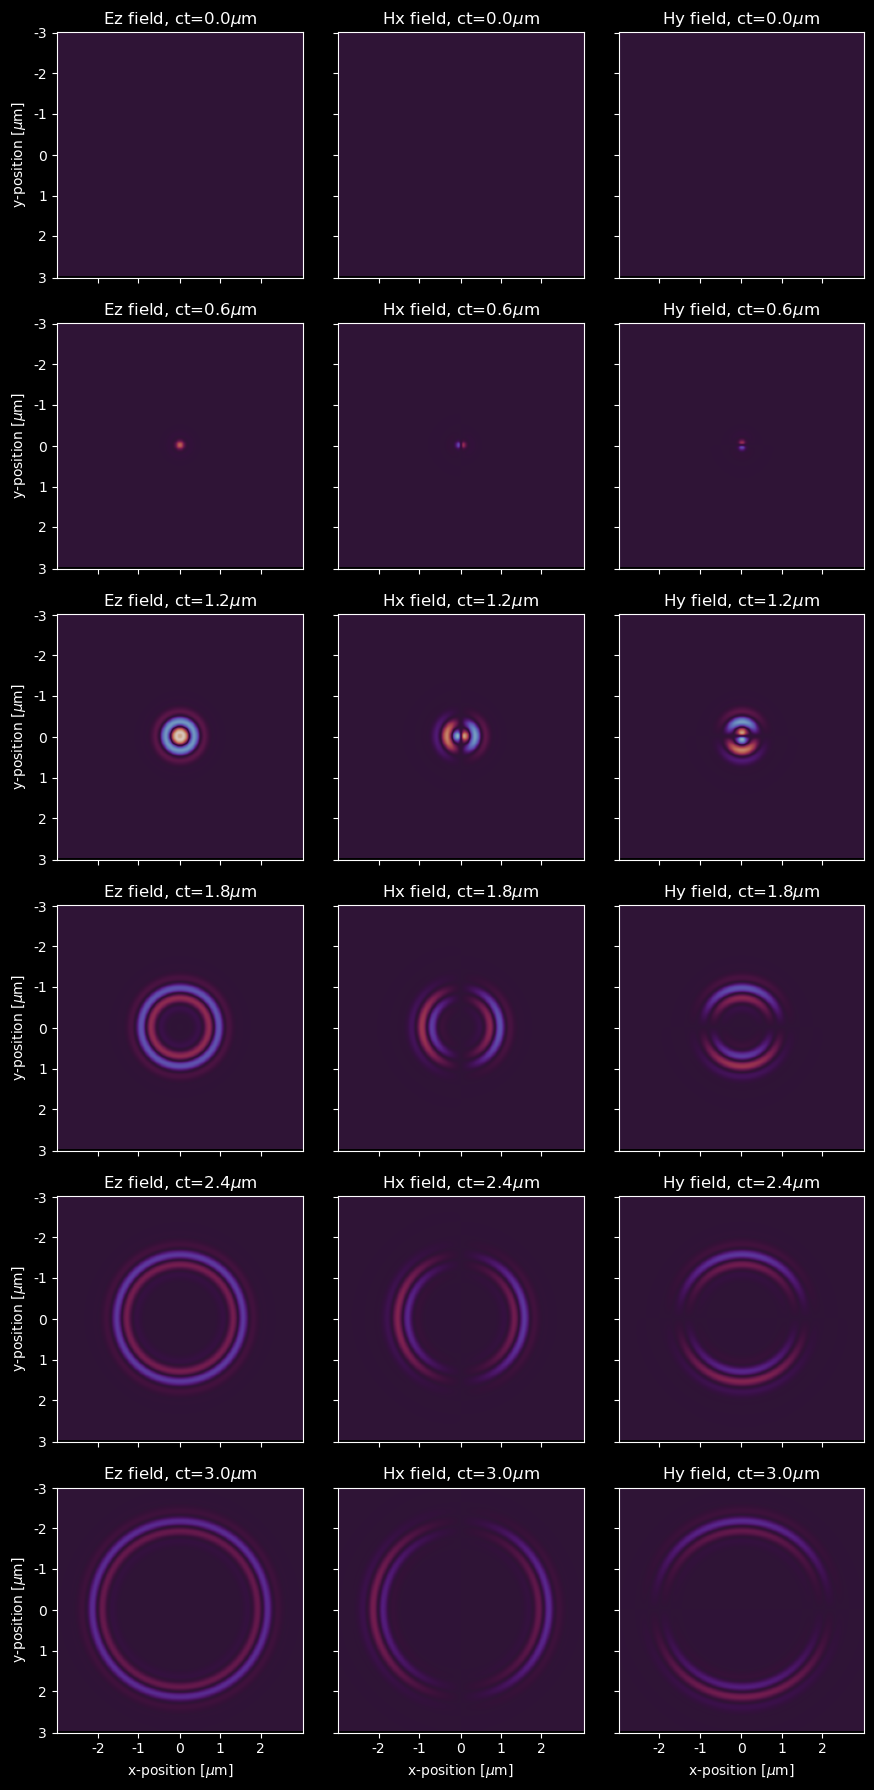

In [74]:
import matplotlib.cm as cm
import matplotlib.colors as color
fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharey='all', sharex='all')
norm = color.Normalize(-6, 6)
cmap = cm.ScalarMappable(norm=norm, cmap='twilight')
Ez_plot = Ez[::10,:,:].real * 1e6
Hx_plot = Hx[::10,:,:].real * 1e6 * Z0
Hy_plot = Hy[::10,:,:].real * 1e6 * Z0
t_plot = t[::10]
for i in range(6):
    axes[i,0].imshow(Ez_plot[i], cmap='twilight', vmin=-6, vmax=6)
    axes[i,0].set_title(r'Ez field, ct=%.1f$\mu$m'%(c*t_plot[i]*1e6))
    axes[i,0].set_ylabel(r'y-position [$\mu$m]')
    axes[i,1].imshow(Hx_plot[i], cmap='twilight', vmin=-6, vmax=6)
    axes[i,1].set_title(r'Hx field, ct=%.1f$\mu$m'%(c*t_plot[i]*1e6))
    axes[i,2].imshow(Hy_plot[i], cmap='twilight', vmin=-6, vmax=6)
    axes[i,2].set_title(r'Hy field, ct=%.1f$\mu$m'%(c*t_plot[i]*1e6))
axes[5,0].set_xlabel(r'x-position [$\mu$m]')
axes[5,1].set_xlabel(r'x-position [$\mu$m]')
axes[5,2].set_xlabel(r'x-position [$\mu$m]')
axes[0,0].set_xticks([33, 66, 100, 133, 166], [-2, -1, 0, 1, 2])
axes[0,0].set_yticks([0, 33, 66, 100, 133, 166, 200], [-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()

# 3. Convergence test
## 1D case
### conservation of energy

In this test, dt is fixed as finest discretization in order to be valid for simulation.

In [8]:
def fdtd_1d_convergence_fixed_time(eps_rel, dx, time_span, source_frequency, source_position,
            source_pulse_length):
    '''Computes the temporal evolution of a pulsed excitation using the
    1D FDTD method. The temporal center of the pulse is placed at a
    simulation time of 3*source_pulse_length. The origin x=0 is in the
    center of the computational domain. All quantities have to be
    specified in SI units.

    Arguments
    ---------
        eps_rel : 1d-array
            Rel. permittivity distribution within the computational domain.
        dx : float
            Spacing of the simulation grid (please ensure dx <= lambda/20).
        time_span : float
            Time span of simulation.
        source_frequency : float
            Frequency of current source.
        source_position : float
            Spatial position of current source.
        source_pulse_length :
            Temporal width of Gaussian envelope of the source.
    '''
    # constants
    c = 2.99792458e8  
    mu0 = 4 * np.pi * 1e-7  
    eps0 = 1 / (mu0 * c ** 2)
    dt = 10e-9 / (2*c)
    e = dt / eps0 
    m = dt / mu0
    
    lam = c/source_frequency
    
    if dx > lam/20/np.sqrt(np.max(eps_rel)):
        dx = lam/20/np.sqrt(np.max(eps_rel))
    else:
        pass
    
    # temporal and spatial coordinate
    Nx = eps_rel.size
    x_span = 18e-6
    x = np.linspace(-x_span/2, x_span/2, Nx)
    Nt = int(round(time_span / dt))
    t = np.arange(Nt + 1) * dt

    # allocate field arrays
    Ez = np.zeros((Nt + 1, Nx), dtype=complex)
    Hy = np.zeros((Nt + 1, Nx - 1), dtype=complex)

    # source definition
    t0 = 3 * source_pulse_length
    # determine the position that we want to add source
    source_ind = int(round((source_position - x[0]) / dx))

    for n in range(0, Nt):
        # update Ez field
        # 0 and Nx -1 are determined by boundary conditions
        Ez[n + 1, 1:-1] = (Ez[n, 1:-1]
                + e / dx * (Hy[n, 1:] - Hy[n, :-1]) / eps_rel[1:-1])

        # source current has to  be taken as n + 1/2
        t_source = (n + 0.5) * dt - t0
        j_source = (np.exp(-1j * 2 * np.pi * source_frequency * t_source)  # carrier
                 * np.exp(-(t_source / source_pulse_length) ** 2))  # envelope
        Ez[n + 1, source_ind] -= e / eps_rel[source_ind] * j_source

        # update Hy field
        Hy[n + 1, :] = Hy[n, :] + m / dx * (Ez[n + 1, 1:] - Ez[n + 1, :-1])
    # in order to calculate the poynting vector of field, we need interpolating Hy to make it 
    # overlapped with Ez
    # interpolate Hy in temporal domain
    Hy[1:, :] = 0.5 * (Hy[:-1, :] + Hy[1:, :])
    # additional two columns with zeros at two edges of boundary. 
    Hy = np.pad(Hy, ((0,0),(1,1)), 'edge') 
    # interpolate Hy in spatial domain
    Hy = 0.5 * (Hy[:, 1:] + Hy[:, :-1])
    '''
    Returns
    -------
        Ez : 2d-array
            Z-component of E(x,t) (each row corresponds to one time step)
        Hy : 2d-array
            Y-component of H(x,t) (each row corresponds to one time step)
        x  : 1d-array
            Spatial coordinates of the field output
        t  : 1d-array
            Time of the field output
    '''
    return Ez, Hy, x, t

In [9]:
# constants
c = 2.99792458e8
mu0 = 4 * np.pi * 1e-7
eps0 = 1 / (mu0 * c ** 2)
Z0 = np.sqrt(mu0 / eps0)
# geometry parameters
x_span = 18e-6
n1 = 1
# simulation parameters
time_span = 60e-15
# source parameters
source_frequency = 500e12
source_position = 0
source_pulse_length = 1e-15

###  dx convergence test 
The error is calculated as follows:
$$e = \left|\frac{E_{tot}- E_{tot}^{*}}{E_{tot}^{*}} \right|$$
but since $E_{tot}^{*}$ is unknown, we approximate it with the result with the smallest step size.
Besides, because the number of grid points is not constant in this experiment, the relative error cannot be calculated with the square root of sum of the squared magnitude. Instead, it is approximated by the value of peak power of field for the end of time evolution. 

In [10]:
dx=np.linspace(10, 30, 40)*10**-9
tot_en = np.zeros((40, ))
for i, dxi in enumerate(dx):
    Nx = int(round(x_span/dxi)) + 1 # number of grid points
    eps_rel=np.ones((Nx,))
    Ez, Hy, x, t = fdtd_1d_convergence_fixed_time(eps_rel, dxi, time_span, source_frequency, source_position, source_pulse_length)
    tot_en[i] = np.max(np.abs(Ez[-1, :]))

Text(0.5, 1.0, 'relative error to varying step size')

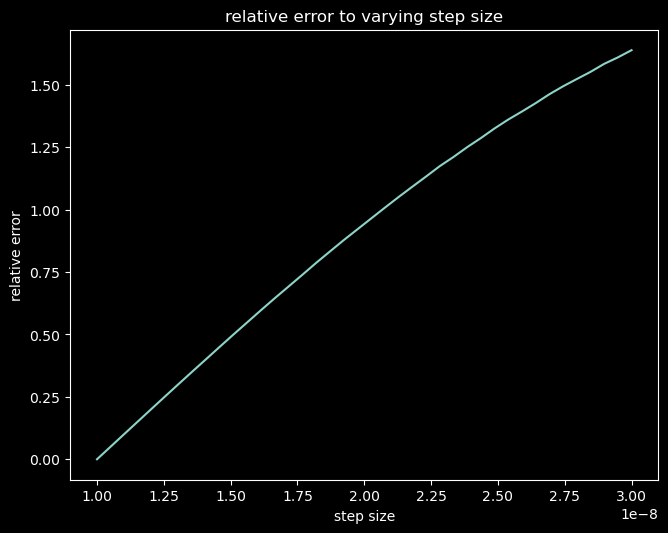

In [11]:
error = np.zeros((40,))

for i in range(40):
    error[i] = np.abs(tot_en[i]/tot_en[0]-1)
plt.figure(figsize = (8, 6))
plt.plot(dx, error)
plt.xlabel('step size')
plt.ylabel('relative error')
plt.title('relative error to varying step size')

This simulation is implemented under explicit scheme. The explicit scheme exhibits an growth due to the instability that causes an amplification of high frequencynoise. Therefore, the relative error would just diverge in this range of simulation step size. 

### dt convergence test 
In this experiment, dx is fixed, and dt acts as variable in the function. In order to be valid for the correlation between dx and dt, dx is taken as 30 nanometer when dt ranges from 15 to 30 nanometer over 2 times speed of light. 

In [12]:
def fdtd_1d_convergence_fixed_grid(eps_rel, dt, time_span, source_frequency, source_position,
            source_pulse_length):
    '''Computes the temporal evolution of a pulsed excitation using the
    1D FDTD method. The temporal center of the pulse is placed at a
    simulation time of 3*source_pulse_length. The origin x=0 is in the
    center of the computational domain. All quantities have to be
    specified in SI units.

    Arguments
    ---------
        eps_rel : 1d-array
            Rel. permittivity distribution within the computational domain.
        dx : float
            Spacing of the simulation grid (please ensure dx <= lambda/20).
        time_span : float
            Time span of simulation.
        source_frequency : float
            Frequency of current source.
        source_position : float
            Spatial position of current source.
        source_pulse_length :
            Temporal width of Gaussian envelope of the source.
    '''
    # constants
    c = 2.99792458e8  
    mu0 = 4 * np.pi * 1e-7  
    eps0 = 1 / (mu0 * c ** 2)
    dx = 30e-9
    e = dt / eps0 
    m = dt / mu0
    
    lam = c/source_frequency
    
    if dx > lam/20/np.sqrt(np.max(eps_rel)):
        dx = lam/20/np.sqrt(np.max(eps_rel))
    else:
        pass
    
    # temporal and spatial coordinate
    Nx = eps_rel.size
    x_span = 18e-6
    x = np.linspace(-x_span/2, x_span/2, Nx)
    Nt = int(round(time_span / dt))
    t = np.arange(Nt + 1) * dt

    # allocate field arrays
    Ez = np.zeros((Nt + 1, Nx), dtype=complex)
    Hy = np.zeros((Nt + 1, Nx - 1), dtype=complex)

    # source definition
    t0 = 3 * source_pulse_length
    # determine the position that we want to add source
    source_ind = int(round((source_position - x[0]) / dx))

    for n in range(0, Nt):
        # update Ez field
        # 0 and Nx -1 are determined by boundary conditions
        Ez[n + 1, 1:-1] = (Ez[n, 1:-1]
                + e / dx * (Hy[n, 1:] - Hy[n, :-1]) / eps_rel[1:-1])

        # source current has to  be taken as n + 1/2
        t_source = (n + 0.5) * dt - t0
        j_source = (np.exp(-1j * 2 * np.pi * source_frequency * t_source)  # carrier
                 * np.exp(-(t_source / source_pulse_length) ** 2))  # envelope
        Ez[n + 1, source_ind] -= e / eps_rel[source_ind] * j_source

        # update Hy field
        Hy[n + 1, :] = Hy[n, :] + m / dx * (Ez[n + 1, 1:] - Ez[n + 1, :-1])
    # in order to calculate the poynting vector of field, we need interpolating Hy to make it 
    # overlapped with Ez
    # interpolate Hy in temporal domain
    Hy[1:, :] = 0.5 * (Hy[:-1, :] + Hy[1:, :])
    # additional two columns with zeros at two edges of boundary. 
    Hy = np.pad(Hy, ((0,0),(1,1)), 'edge') 
    # interpolate Hy in spatial domain
    Hy = 0.5 * (Hy[:, 1:] + Hy[:, :-1])
    '''
    Returns
    -------
        Ez : 2d-array
            Z-component of E(x,t) (each row corresponds to one time step)
        Hy : 2d-array
            Y-component of H(x,t) (each row corresponds to one time step)
        x  : 1d-array
            Spatial coordinates of the field output
        t  : 1d-array
            Time of the field output
    '''
    return Ez, Hy, x, t


In [13]:
# constants
c = 2.99792458e8
mu0 = 4 * np.pi * 1e-7
eps0 = 1 / (mu0 * c ** 2)
Z0 = np.sqrt(mu0 / eps0)

# geometry parameters
x_span = 18e-6
n1 = 1
dx = 30e-9

# simulation parameters
time_span = 60e-15

# source parameters
source_frequency = 500e12
source_position = 0
source_pulse_length = 1e-15

dxx = np.linspace(10, 30, 40)*10**-9
dt = dxx/(2*c)
Nx = int(round(x_span/dx)) + 1 # number of grid points
eps_rel=np.ones((Nx,))

In this case, square root of sum of the squared magnitude of the difference between the propagated field is applied because the grid points are constant for different time steps. 


In [14]:
Ez_out = np.zeros((40, 601))
for i, dti in enumerate(dt):
    Ez, Hy, x, t = fdtd_1d_convergence_fixed_grid(eps_rel, dti, time_span, source_frequency, source_position, source_pulse_length)
    Ez_out[i, :] = np.abs(Ez[-1, :])

Text(0.5, 0, 'step size for time (s)')

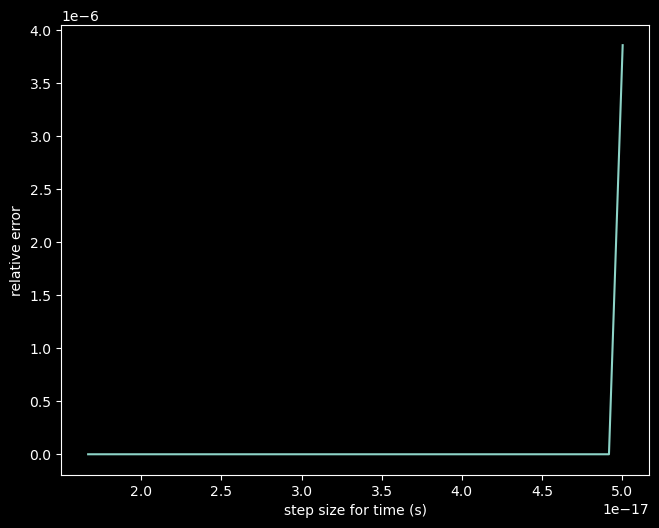

In [15]:
rel_error = np.zeros((40,))
rel_error[i] = np.sqrt(np.sum((Ez_out[i, :]-Ez_out[0, :])**2))
plt.figure(figsize=(8, 6))
plt.plot(dt, rel_error)
plt.ylabel('relative error')
plt.xlabel('step size for time (s)')

This is in explicite scheme; therefore, for both temporal and spatial test, the relative error just increases with respect to the larger step size. 

## 3D case
In this section, we will discuss the influence of the discretization onto the accuracy of the obtained solution. First, we will have a look at the influence of $\Delta$t. The relative error $e$ is given by the root mean square error (RMSE) between the propagated electric field $Ez$ and the true result $Ez^*$ at the time t = 60fs:
$$
e = \sqrt{\frac{\sum\limits_{i=1,j=1}^{Nx,Ny}{E_z^*(i,j)-E_z(i,j)}}{NxNy}}
$$
The true result was approximated by the result at the smallest $\Delta$t(1e-18s), and $\Delta$t values are in the range of (5e-18, 5e-17)s. $\Delta$x was set to 30nm. Figure 8 shows the convergence of the 3d FDTD method with respect to $\Delta$t. As expected, the relative error increases alone the increasing of $\Delta$t. The relative errors are relative small for all tested $\Delta$t.

The influence of the spacial resolution is tested. Because the shapes of output fields are different, we extract the grid points in specific positions to make sure the number of grid points keep in constant before calculating the RMSE. $\Delta$t is set to 2.5e-18s. For reducing the computation time, the spacial span is set to $x = y = 1.5\mu m$, time span to t=4.5fs, and output step to 40. The result is shown in Fig. 9. The influence of the spacial resolution have a similar behaviour as the temporal resolution. It increases with respect to the larger step size and keeps in a relative small values.

In [33]:
Nx = 199 # number of grid points in x-direction
Ny = 201 # number of grid points in y-direction
Nz = 5   # number of grid points in z-direction
dr = 30e-9 # grid spacing in [m]
time_span = 10e-15 # duration of simulation [s]
freq = 500e12 # pulse [Hz]
tau = 1e-15 # pulse width [s]
source_width = 2 # width of Gaussian current dist. [grid points]
w = source_width * dr

eps_rel = np.ones((Nx, Ny, Nz))
jx = np.zeros((Nx, Ny, Nz))
jy = np.zeros((Nx, Ny, Nz))
x = np.linspace(-(Nx//2), Nx//2, Nx) * dr
y = np.linspace(-(Ny//2), Ny//2, Ny) * dr
YY, XX = np.meshgrid(y, x)
jz = np.exp(-(XX**2+YY**2)/w**2)
jz = jz[..., np.newaxis]
jz = np.repeat(jz, 5, 2)

midz = int(np.ceil((Nz-1)/2))
z_ind = midz
output_step = 10

In [17]:
ref, t = fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, field_component='ez', z_ind=z_ind, output_step=output_step, dt= 5e-17 /50)
dt = 5e-17 / np.linspace(1, 10, 19)
results = []
for dti in dt:
    Ez, t = fdtd_3d(eps_rel, dr, time_span, freq, tau, jx, jy, jz, field_component='ez', z_ind=z_ind, output_step=output_step, dt=dti)
    results.append(Ez)

In [18]:
err_dt = []
for res in results:
    e = np.sqrt(np.mean(np.square(res.real[-1] - ref.real[-1])))
    err_dt.append(e)

In [19]:
len_x = 50 * 30e-9
len_y = 50 * 30e-9
time_span = 4.5e-15
dt = 50e-18
output_step = 40
dr = 30e-9 / np.linspace(1, 20, 20)
results_dx = []
for dri in dr:
    Nx = int(round(len_x / dri) + 1)
    Ny = int(round(len_y / dri) + 1)
    eps_rel = np.ones((Nx, Ny, Nz))
    x = np.linspace(-(Nx // 2), Nx // 2, Nx) * dri
    y = np.linspace(-(Ny // 2), Ny // 2, Ny) * dri
    jx = np.zeros((Nx, Ny, Nz))
    jy = np.zeros((Nx, Ny, Nz))
    YY, XX = np.meshgrid(y, x)
    jz = np.exp(-(XX ** 2 + YY ** 2) / w ** 2)
    jz = jz[..., np.newaxis]
    jz = np.repeat(jz, 5, 2)
    Ez, t = fdtd_3d(eps_rel, dri, time_span, freq, tau, jx, jy, jz, field_component='ez', z_ind=z_ind, output_step=40, dt=5e-18 / 2)
    results_dx.append(Ez)

In [20]:
err_dx = []
ref = results_dx[-1]
ref = ref[-1,::20,::20]
for dri, res in zip(np.linspace(1, 19, 19).astype('int'), results_dx):
    res = res[-1,::dri,::dri]
    e = np.sqrt(np.mean(np.square(res.real - ref.real)))
    err_dx.append(e)

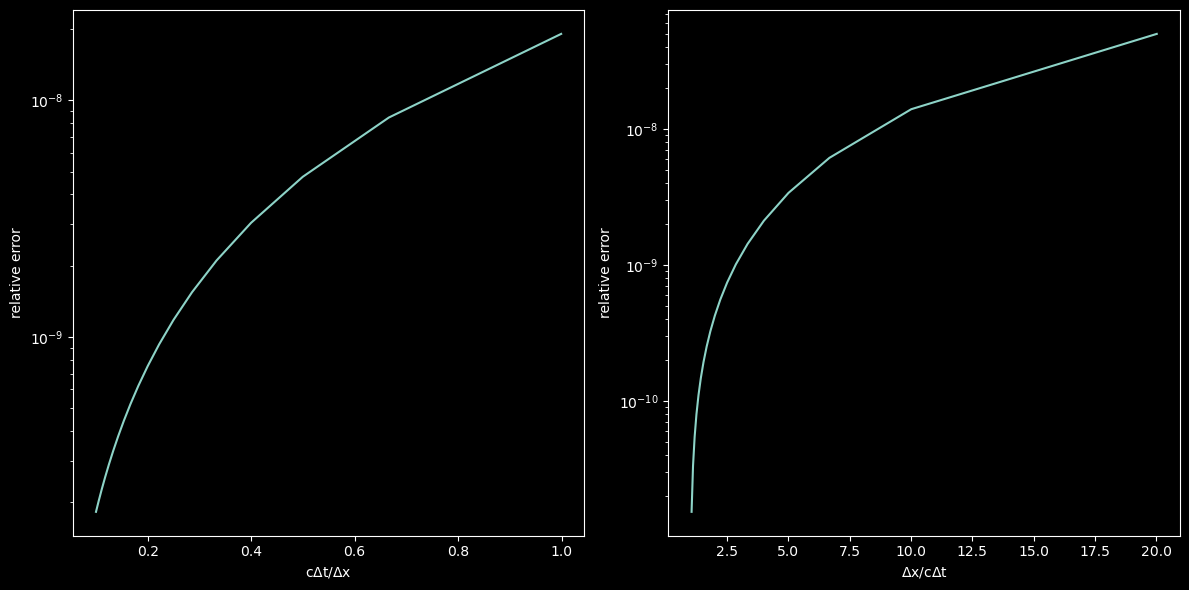

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
dt = 5e-17 / np.linspace(1, 10, 19)
axes[0].plot(dt*2*c/30e-9, err_dt)
axes[0].set_xlabel(r'c$\Delta$t/$\Delta$x')
dr = 30e-9 / np.linspace(1, 20, 20)
axes[1].plot(dr[:-1]/2/c/2.5e-18, err_dx)
axes[1].set_xlabel(r'$\Delta$x/c$\Delta$t')
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylabel('relative error')
plt.tight_layout()